In [1]:
import cv2
import os
import numpy as np
from os.path import join
from pathlib import Path
import re
import json
from typing import List, Tuple, Any, Union
import pandas as pd
import imutils
import matplotlib.patches as patches
import matplotlib.pyplot as plt
SIZE = 20

## Get the first Image of the Video

In [2]:
def get_video_image(
        video_path: str, 
        frame_number: int,
        output_folder: str = None):
    """
    Get the image from the video at the given frame number.
    """
    video = cv2.VideoCapture(video_path)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, image = video.read()
    # print("Return value: ", ret)
    if not ret:
        raise Exception("Could not read image at frame number: ", frame_number)
    # get participant name from video path
    participant_name = re.search(r'(?<=participants/)[^/]+', video_path).group(0)
    image_path = None
    if output_folder:
        Path(output_folder).mkdir(parents=True, exist_ok=True)
        image_path = join(output_folder, f"{participant_name}_frame_{frame_number}.jpg")
        cv2.imwrite(image_path, image)
    return image, image_path


img, img_path = get_video_image(
    video_path="../participants/UconsumerU/video_export_07-26-22-15.10.45_UconsumerU 0.avi", 
    frame_number=1000,
    output_folder="../participants/UconsumerU/frames")


In [3]:
def get_first_white_screen(
        video_path: str, 
        output_folder: str = None,
        whiteness_threshold: str = 180,
        start_frame: int = 0,
        scan_every_n_frames: int = 50):
    """Iterate over frames until we find a screen which is mostly white."""
    white_screen_found = False
    c_frame = start_frame
    while not white_screen_found:
        c_frame += scan_every_n_frames
        img, _ = get_video_image(
            video_path=str(video_path),
            frame_number=c_frame)
        # get the average value of a pixel in the screenshot
        avg_value = np.average(img)
        if avg_value > whiteness_threshold:
            white_screen_found = True
    return get_video_image(
        video_path=str(video_path),
        frame_number=c_frame,
        output_folder=output_folder)

In [4]:
def cut_image(
        image_array,
        x_start_cut: int = 0,
        y_start_cut: int = 0,
        x_end_cut: int = None, 
        y_end_cut: int = None):
    """Cut an image."""
    if x_end_cut is None:
        x_end_cut = image_array.shape[1]
    if y_end_cut is None:
        y_end_cut = image_array.shape[0]
    # convert all to integer values
    x_start_cut = int(x_start_cut)
    x_end_cut = int(x_end_cut)
    y_start_cut = int(y_start_cut)
    y_end_cut = int(y_end_cut)
    return image_array[y_start_cut:y_end_cut, x_start_cut:x_end_cut, :]


In [5]:
img.shape

(1080, 1920, 3)

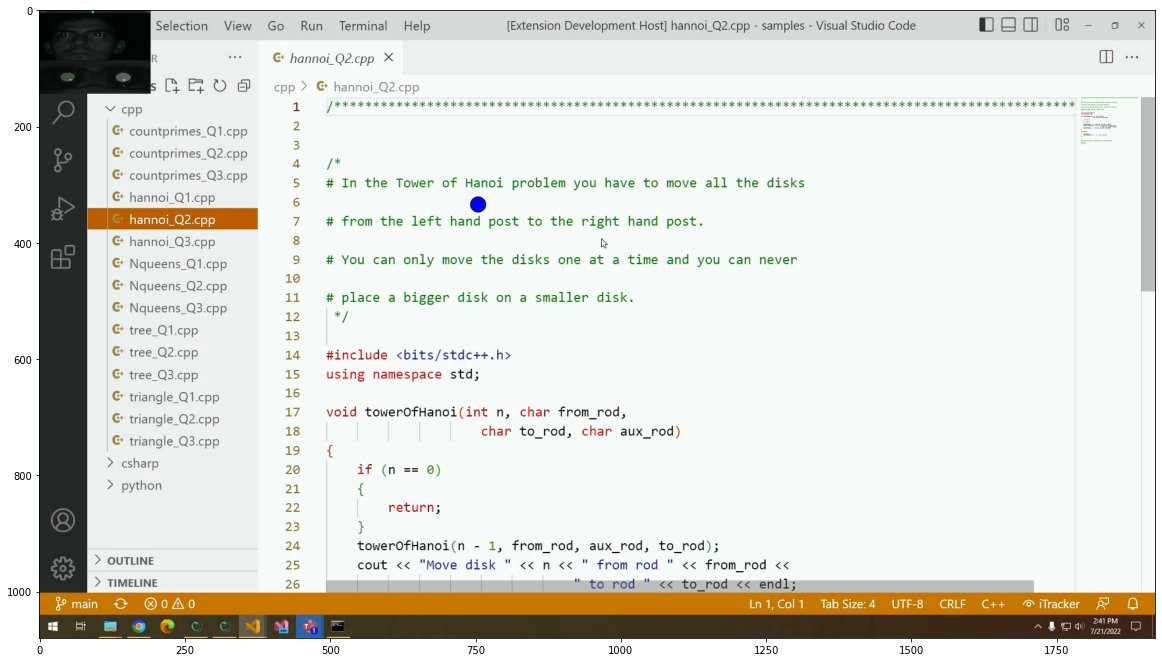

In [6]:
img, img_path =get_video_image(
    video_path="../participants/UconsumerU/video_export_07-26-22-15.10.45_UconsumerU 0.avi",
    frame_number=1000,
    output_folder="../participants/UconsumerU/frames")
plt.imshow(img)
plt.gcf().set_size_inches((SIZE, SIZE))

## Locate the Screen Corners

In [7]:

def get_coordinate_of(marker_path: str, screen_path: str, debug: bool = False):
    """Locate the coordinate of the marker in the given iamge."""
    # load marker image
    template = cv2.imread(marker_path)
    # load screen image
    image = cv2.imread(screen_path)

    # convert both the image and template to grayscale
    template = cv2.Canny(template, 50, 200)
    (tH, tW) = template.shape[:2]
    if debug:
        plt.imshow(template)
    # load the image, convert it to grayscale, and initialize the
    # bookkeeping variable to keep track of the matched region
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    found = None
    # loop over the scales of the image
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        # resize the image according to the scale, and keep track
        # of the ratio of the resizing
        resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        # if the resized image is smaller than the template, then break
        # from the loop
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break		
        # detect edges in the resized, grayscale image and apply template
        # matching to find the template in the image
        edged = cv2.Canny(resized, 50, 200)
        result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
        (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
        # check to see if the iteration should be visualized
        # if we have found a new maximum correlation value, then update
        # the bookkeeping variable
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)
    # unpack the bookkeeping variable and compute the (x, y) coordinates
    # of the bounding box based on the resized ratio
    (_, maxLoc, r) = found
    (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
    (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
    # draw a bounding box around the detected result and display the image
    #plt.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    if debug:
        fig, ax = plt.subplots(1, figsize=(SIZE, SIZE))
        ax.imshow(image)
        rect = patches.Rectangle((startX, startY), endX-startX, endY-startY, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.show()
    return startX, startY, endX, endY
    

def get_code_coordinates(
        screenshot_path: str, 
        path_marker_top_left: str = "../markers/top_left_marker.png", 
        path_marker_bottom_right: str = "../markers/bottom_right_marker.png",
        top_left_offsets: Tuple[int, int] = (182, 109),
        bottom_right_offsets: Tuple[int, int] = (107, 6),
        percentage_format: bool = False, 
        debug: bool = False):
    """Find the screen markers in the screenshot."""

    # cut to consider only the upper right corner
    img = cv2.imread(screenshot_path)
    img_height, img_width = img.shape[:2]
    img_cut = cut_image(img, 0, 0, img_width * .3, img_height*.2)
    # save to file
    screenshot_path_cut = screenshot_path.replace(".jpg", "_cut.jpg")
    cv2.imwrite(screenshot_path_cut, img_cut)

    # get top-left screen coordinates    
    startX, startY, endX, endY = get_coordinate_of(
        marker_path=path_marker_top_left,
        screen_path=screenshot_path_cut,
        debug=debug
    )

    horizontal_screen_start = startX + top_left_offsets[0]
    vertical_screen_start = startY + top_left_offsets[1]

    # get bottom-right screen coordinates
    
    startX, startY, endX, endY = get_coordinate_of(
        marker_path=path_marker_bottom_right,
        screen_path=screenshot_path,
        debug=debug
    )

    horizontal_screen_end = startX + bottom_right_offsets[0]
    vertical_screen_end = startY + bottom_right_offsets[1]

    # visualize result
    if debug:
        fig, ax = plt.subplots(1, figsize=(SIZE, SIZE))
        image = cv2.imread(screenshot_path)
        ax.imshow(image)

        ax.axvline(horizontal_screen_start, color='r', linewidth=1)
        ax.axhline(vertical_screen_start, color='r', linewidth=1)

        ax.axvline(horizontal_screen_end, color='r', linewidth=1)
        ax.axhline(vertical_screen_end, color='r', linewidth=1)
        plt.show()

    if percentage_format:
        return {
            "x_start_screen_perc": horizontal_screen_start / image.shape[1],
            "y_start_screen_perc": vertical_screen_start / image.shape[0],
            "x_end_screen_perc": horizontal_screen_end / image.shape[1],
            "y_end_screen_perc": vertical_screen_end / image.shape[0]
        }

    return {
        "x_start_screen_abs": horizontal_screen_start,
        "y_start_screen_abs": vertical_screen_start,
        "x_end_screen_abs": horizontal_screen_end,
        "y_end_screen_abs": vertical_screen_end
    }

screen_coordinate_abs = get_code_coordinates(
    screenshot_path=img_path,
    percentage_format=False,
    debug=False)
screen_coordinate_abs

{'x_start_screen_abs': 493,
 'y_start_screen_abs': 151,
 'x_end_screen_abs': 1785,
 'y_end_screen_abs': 1000}

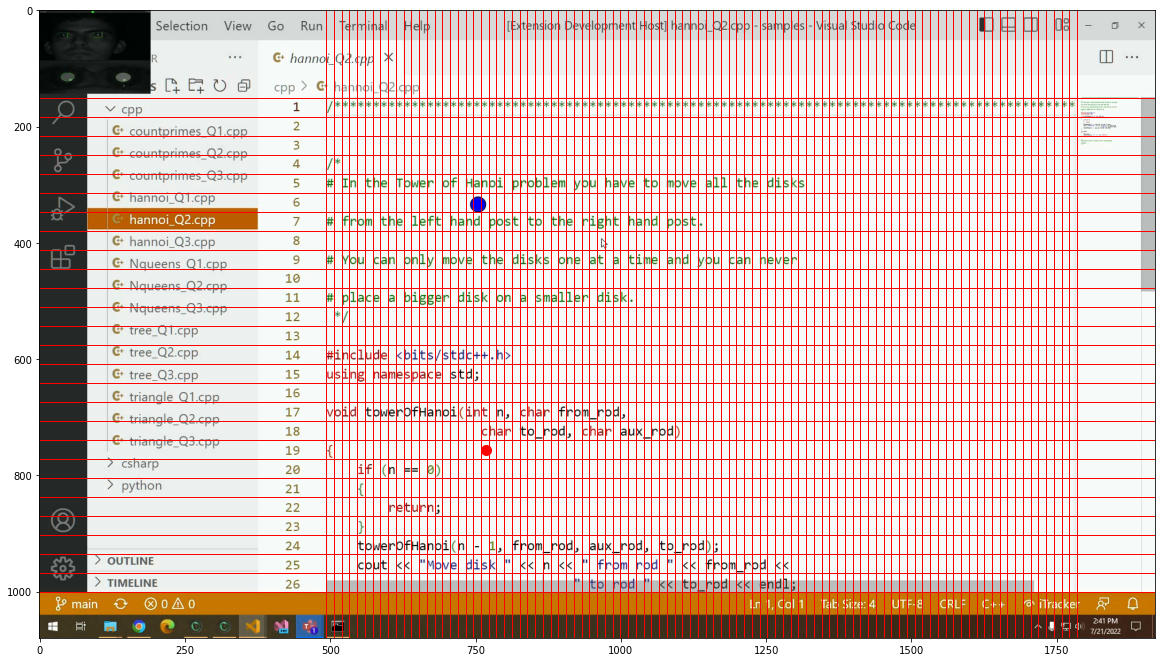

(18, 20)

In [8]:
def get_char_coordinates(
        eye_x_perc, eye_y_perc,
        x_start_screen_abs: float, 
        y_start_screen_abs: float, 
        x_end_screen_abs: float, 
        y_end_screen_abs: float, 
        n_lines: int = 26,
        n_col: int = 97,
        screen_path: str = None,
        pixel_screen_width: int = None, pixel_screen_height: int = None,
        ax = None,
        debug: bool = True
        ) -> Tuple[int, int]:
    """It converts a screen percentage to a specific (line, column) coordinate.
    
    Remember to provide either the screen_path or the pixel width and height, 
    otherwise we have no way to figure out how large the screen is.
    Note that the coordinate system starts from 0 for both lines and columns.
    Thus the top left character of the code screen is (0, 0).
    """
    image = None
    if pixel_screen_width is None or pixel_screen_height is None:
        image = cv2.imread(screen_path)
        pixel_screen_width = image.shape[1]
        pixel_screen_height = image.shape[0]
    code_area_width = x_end_screen_abs - x_start_screen_abs
    code_area_height = y_end_screen_abs - y_start_screen_abs
    char_width = code_area_width / n_col
    char_height = code_area_height / n_lines

    col_separators = [
        x_start_screen_abs + char_width * i 
        for i in range(n_col + 1)
    ]
    line_separators = [
        y_start_screen_abs + char_height * i
        for i in range(n_lines + 1)
    ]
    
    # convert eye cursor in absolute
    eye_x_abs = eye_x_perc * pixel_screen_width
    eye_y_abs = eye_y_perc * pixel_screen_height

    # get the column index
    col_index = 0
    for i in range(len(col_separators) - 1):
        if col_separators[i] <= eye_x_abs < col_separators[i + 1]:
            col_index = i
            break
    # get the line index
    line_index = 0
    for i in range(len(line_separators) - 1):
        if line_separators[i] <= eye_y_abs < line_separators[i + 1]:
            line_index = i
            break

    if debug:
        # visualize
        if ax is None:
            fig, ax = plt.subplots(1, figsize=(SIZE, SIZE))
        if not image:
            image = cv2.imread(screen_path)
        ax.imshow(image)
        for col_sep in col_separators:
            ax.axvline(col_sep, color='r', linewidth=1)
        for line_sep in line_separators:
            ax.axhline(line_sep, color='r', linewidth=1)
        # add a point in the eye cursor
        ax.scatter(eye_x_abs, eye_y_abs, c='red', s=100)
        plt.show()
    return (line_index, col_index)


def convert_to_absolute(perc_coordinate: float, total_space: int): 
    """Convert a percentage coordinate to an absolute coordinate."""
    return int(perc_coordinate * total_space)
    
code_screen_coordinate_abs = get_code_coordinates(
    screenshot_path=img_path,
    top_left_offsets=(182, 109),
    bottom_right_offsets=(107, 6),
    percentage_format=False,
    debug=False)

get_char_coordinates(
    eye_x_perc=0.4, eye_y_perc=0.7,
    pixel_screen_width=1920, pixel_screen_height=1080,
    screen_path=img_path,
    debug=True,
    **code_screen_coordinate_abs)


## Multiple Users

In [9]:

# depending on the user we have different market depending on their zoom
# level, either medium or large
VALID_USERNAMES_AND_ZOOM = [
    ["UconsumerU", "M"],
    ["Antonella", "L"],
    ["Beth", "L"],
    ["Diane", "M"],
    ["Ella", "L"],
    ["Eva", "M"],
    ["Sabastian", "M"],
    ["Yaaseen", "L"],
]

Scraping participant:  Pedro
../participants/Pedro/video_export_07-26-22-15.15.14_Pedro 3.avi
../participants/Pedro/frames


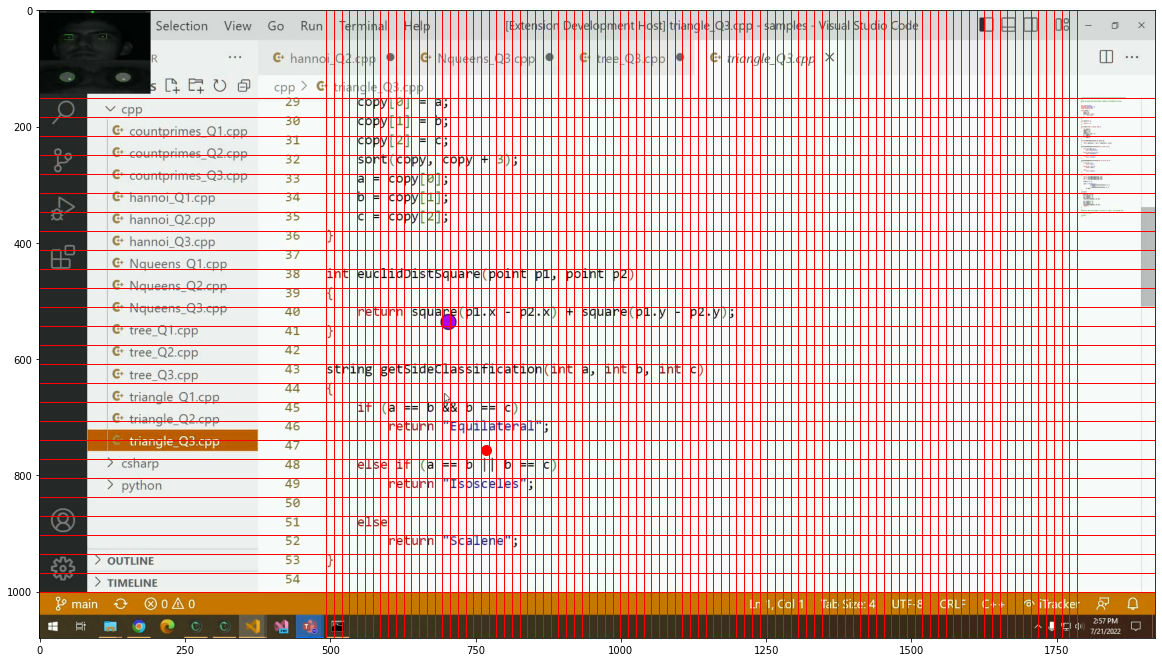

Scraping participant:  Antonella
../participants/Antonella/video_export_07-20-22-14.00.38_User 1.avi
../participants/Antonella/frames


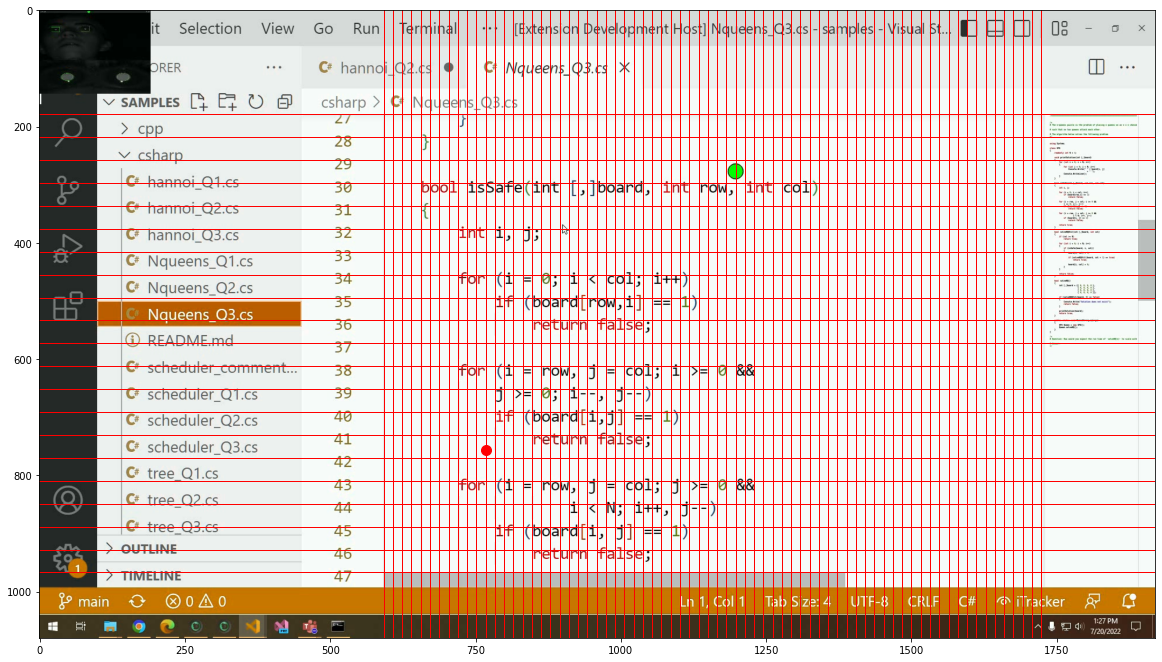

Scraping participant:  Beth
../participants/Beth/video_export_07-20-22-11.50.31_Beth4.avi
../participants/Beth/frames


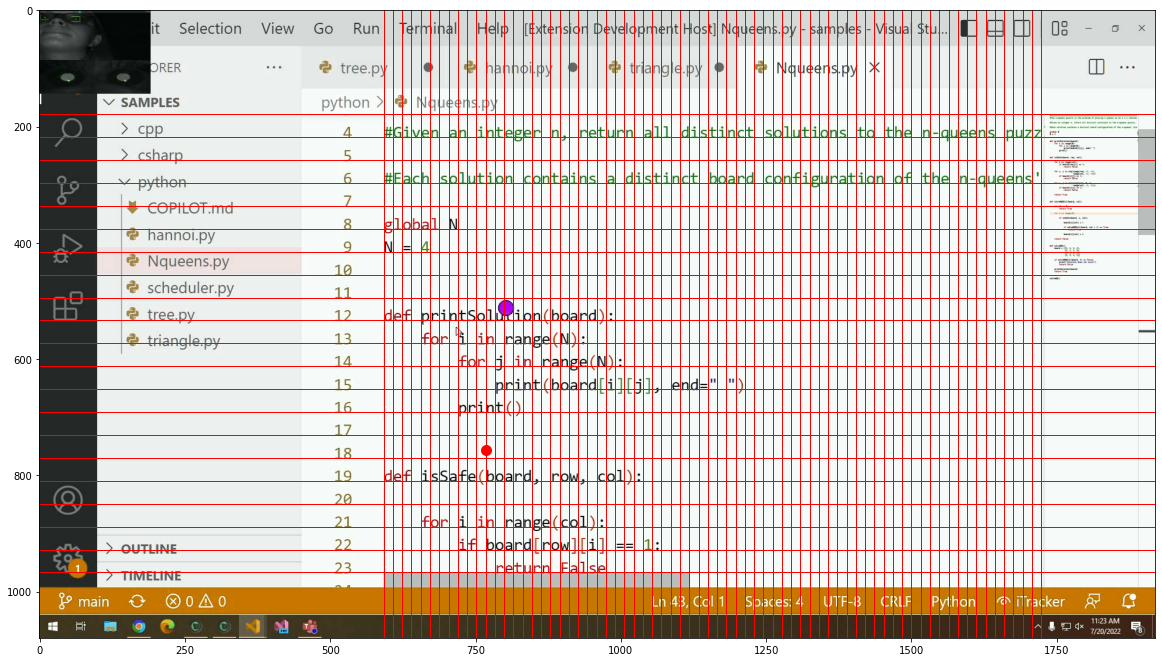

Scraping participant:  Diane
../participants/Diane/video_export_07-26-22-14.43.44.avi
../participants/Diane/frames


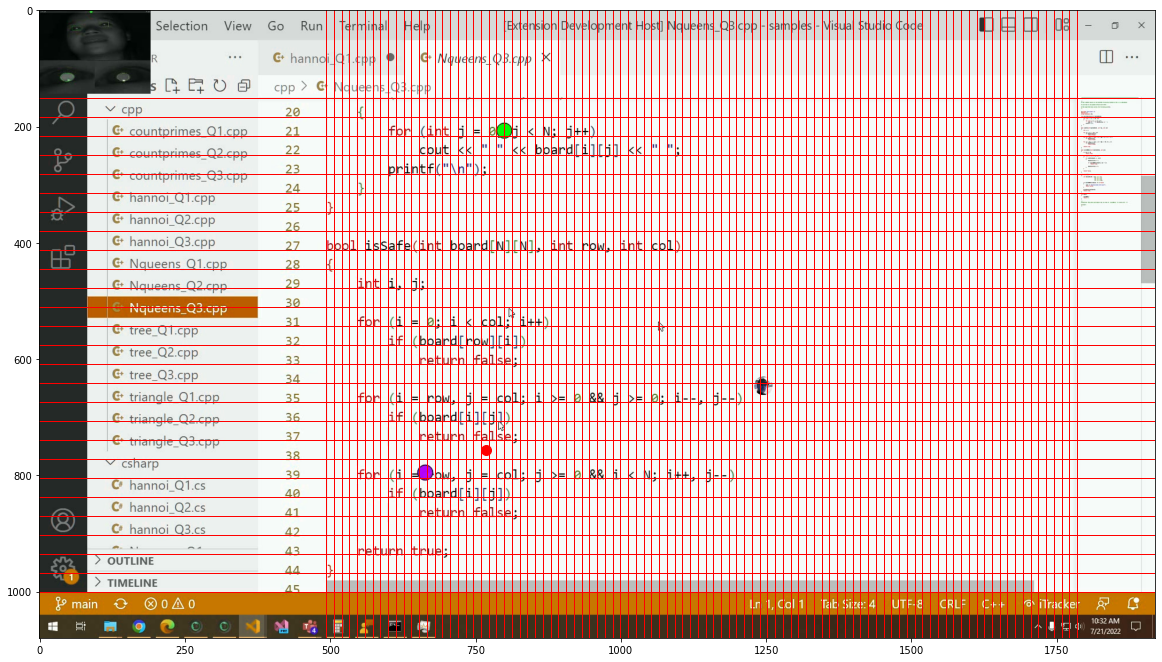

Scraping participant:  Ella
../participants/Ella/video_export_07-20-22-11.55.56_Ella1.avi
../participants/Ella/frames


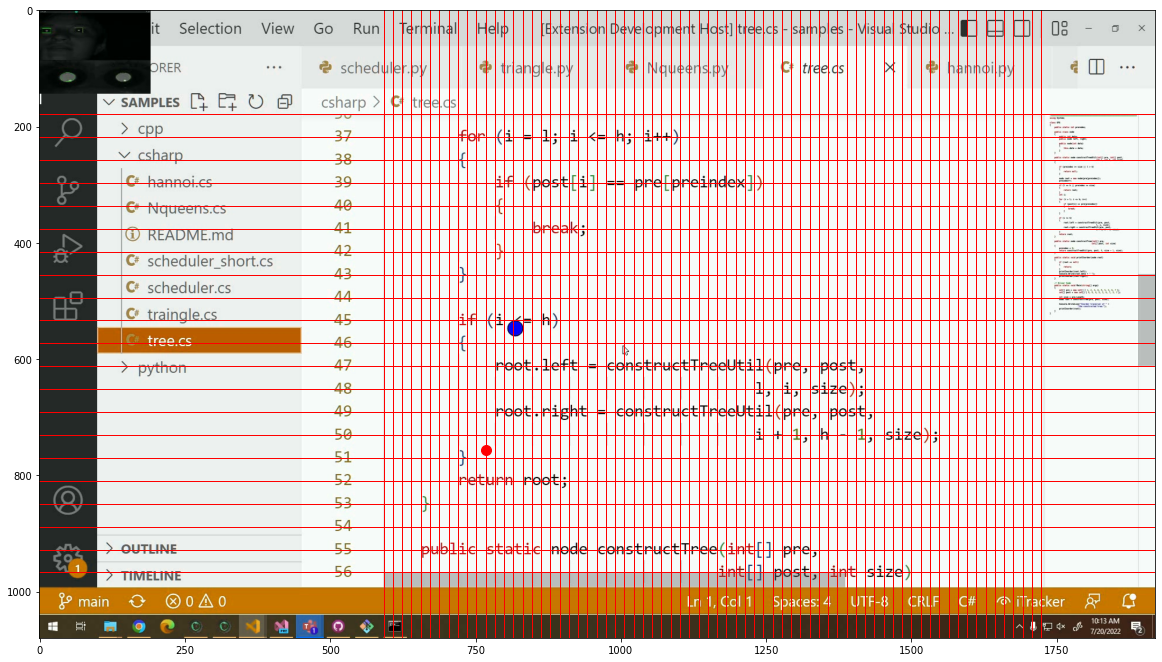

Scraping participant:  Eva
../participants/Eva/video_export_07-26-22-14.59.15_Eva 0.avi
../participants/Eva/frames


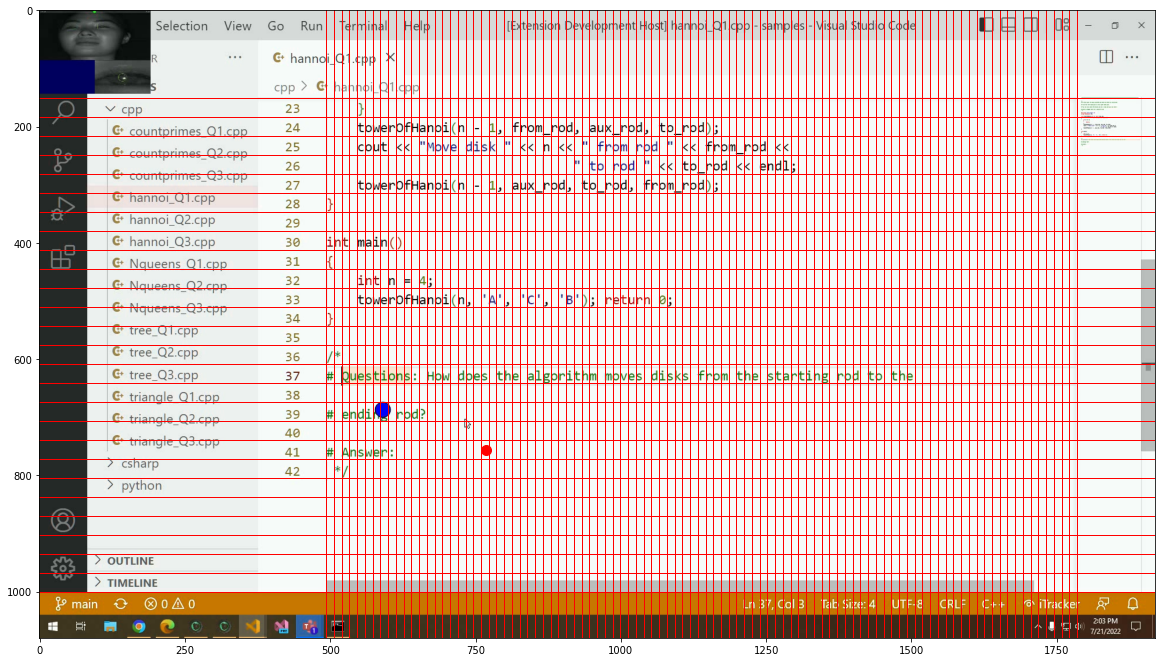

Scraping participant:  Sabastian
Skipping video:  ../participants/Sabastian  because of lack of video footage.
../participants/Eva/video_export_07-26-22-14.59.15_Eva 0.avi
../participants/Sabastian/frames


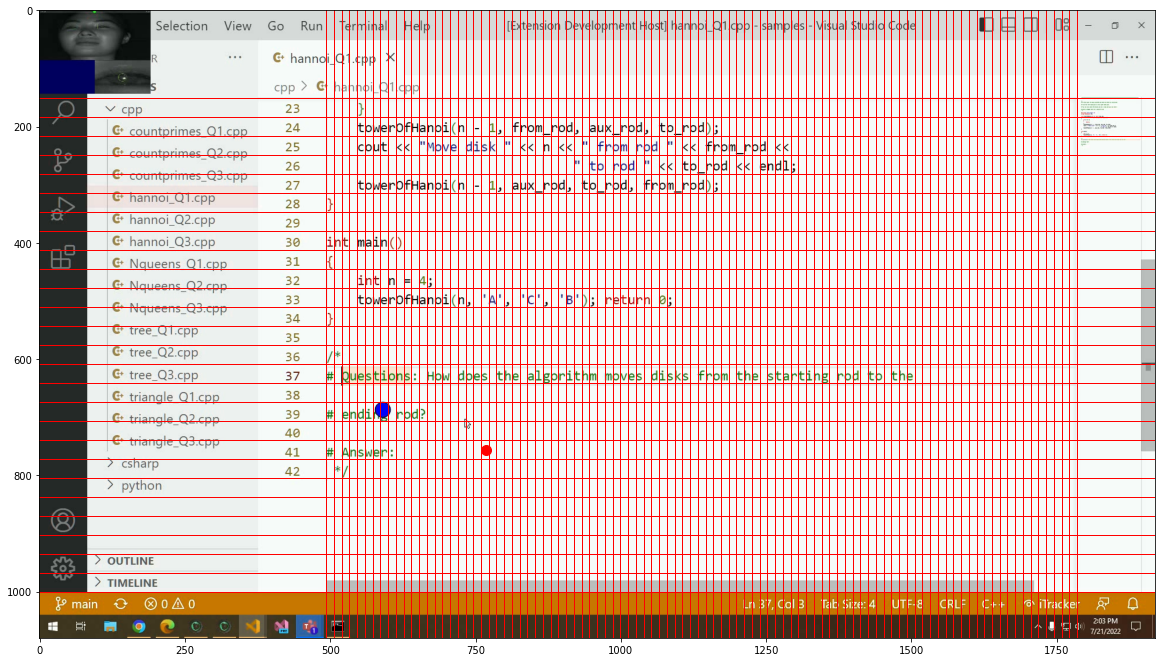

Scraping participant:  Yaaseen
../participants/Yaaseen/video_export_07-20-22-15.56.50_Yaaseen 0.avi
../participants/Yaaseen/frames


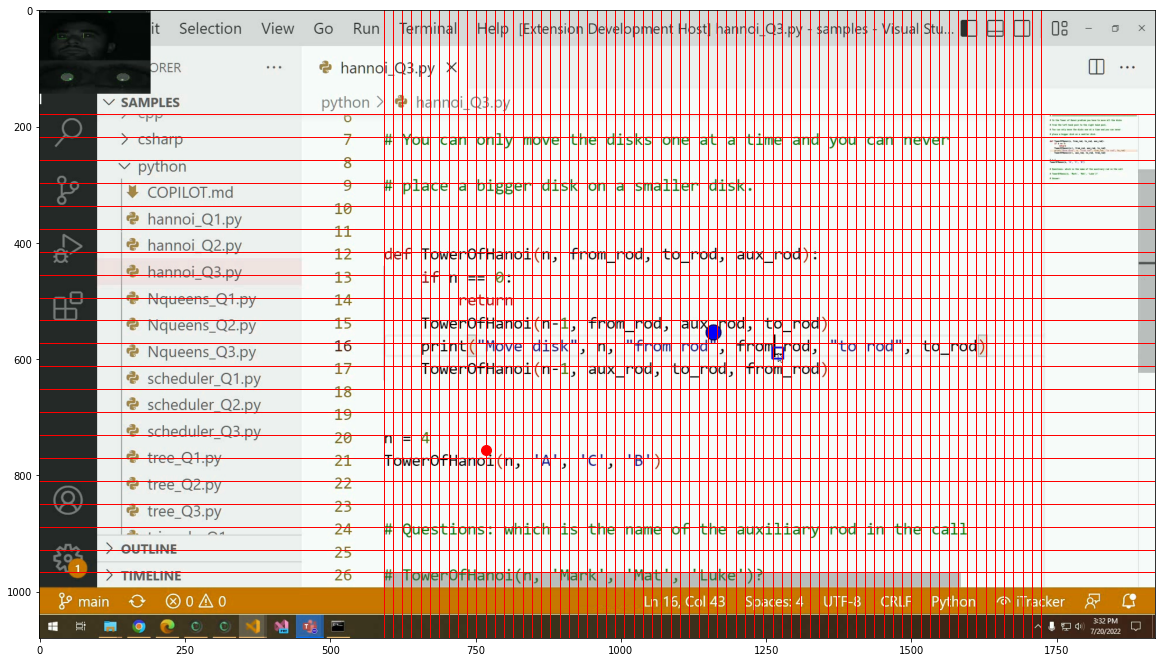

In [10]:
# iterate over all the participants
for participant_name, zoom_level in VALID_USERNAMES_AND_ZOOM:
    print("Scraping participant: ", participant_name)
    # get the path of the first avi file of the participant
    path_participant = Path(join("..", "participants", participant_name))
    try:
        video_path = list(path_participant.glob("*.avi"))[0]
    except IndexError:
        print("Skipping video: ", path_participant, " because of lack of video footage.")
    print(video_path)
    # get the path of the folder where the frames will be saved
    output_folder = join(str(path_participant), "frames")
    print(output_folder)
    # get the screenshot of the first frame of the video
    img, screen_path = get_first_white_screen(
        video_path=str(video_path),
        output_folder=output_folder,
        start_frame=1000)
    
    if zoom_level == "M":
        code_screen_coordinate_abs = get_code_coordinates(
            screenshot_path=screen_path,
            path_marker_top_left="../markers/top_left_marker.png", 
            path_marker_bottom_right="../markers/bottom_right_marker.png",
            top_left_offsets=(182, 109),
            bottom_right_offsets=(107, 6),
            percentage_format=False,
            debug=False)
        
        get_char_coordinates(
            eye_x_perc=0.4, eye_y_perc=0.7,
            pixel_screen_width=1920, pixel_screen_height=1080,
            screen_path=screen_path,
            n_lines=26,
            n_col=97,
            debug=True,
            **code_screen_coordinate_abs)
    elif zoom_level == "L":
        code_screen_coordinate_abs = get_code_coordinates(
            screenshot_path=screen_path,
            path_marker_top_left="../markers/top_left_marker_zoomed.png", 
            path_marker_bottom_right="../markers/bottom_right_marker_zoomed.png",
            top_left_offsets=(220, 125),
            bottom_right_offsets=(90, -25),
            percentage_format=False,
            debug=False)
        
        get_char_coordinates(
            eye_x_perc=0.4, eye_y_perc=0.7,
            pixel_screen_width=1920, pixel_screen_height=1080,
            screen_path=screen_path,
            n_lines=20,
            n_col=71,
            debug=True,
            **code_screen_coordinate_abs)



    

# Full-Pipeline 

In [11]:
USER_NAME = "UconsumerU"
USER_ZOOM = "M"
VIDEO_FILE = "../participants/UconsumerU/video_export_07-26-22-15.10.45_UconsumerU 0.avi"
EYE_TRACKER_FILE = "../participants/UconsumerU/UconsumerU 0_fixations.csv"

## Synchronized Timestamps
### 1. Code Snapshot (source: iTracker VSCode extension)

In [12]:
from datetime import datetime

def convert_string_to_day_time(snapshot_filename: str) -> int:
    """Convert a snapshot string to the number of millisecond of that day."""
    # remove file extension
    time_string = snapshot_filename.split(".")[0]
    # get the date and time of the snapshot
    date_time = datetime.strptime(
        time_string,
        #"%H-%M-%S-%I-%f"
        "%I-%M-%S-%p-%f"
    )
    # print(date_time)
    # get the number of milliseconds seconds in date time
    return (date_time - datetime(1900, 1, 1)).total_seconds() * 1000


def read_textual_snapshot(user_folder: str):
    """Read the textual snapshot of the code screen."""
    records = []
    # if the record.json exists read that
    record_path = join(user_folder, "Snapshots", "record.json")
    if os.path.exists(record_path):
        with open(record_path, "r") as f:
            records = json.load(f)
        return pd.DataFrame.from_records(records)
    for snapshot_filename in os.listdir(user_folder, "Snapshots"):
        file = open(join(user_folder, "Snapshots", snapshot_filename), "r")
        lines = file.readlines()
        record = {
            "time": convert_string_to_day_time(snapshot_filename),
            "source_filename": lines[0],
            "content_lines": lines[1:]
        }
        records.append(record)
    # dump records to a json file
    with open(record_path, "w") as f:
        json.dump(records, f)
    return pd.DataFrame.from_records(records)

def get_textual_snapshot_at(df_snapshots: pd.DataFrame, time_ms: int):
    """Get the textual snapshot at a given time."""
    df_snapshots = df_snapshots.sort_values(by="time")
    df_previous_states = df_snapshots.loc[df_snapshots["time"] < time_ms]
    # get last row
    last_row = df_previous_states.iloc[-1].to_dict()
    return last_row


convert_string_to_day_time("2-40-59-PM-645.txt")
df = read_textual_snapshot(f"../participants/{USER_NAME}")
df

time                                    source_filename  \
0    52861870.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
1    53784778.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
2    52893420.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
3    53813552.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
4    53743264.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
..          ...                                                ...   
751  53789144.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
752  53825528.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
753  53572950.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
754  53766850.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   
755  53553589.0  c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...   

                                         content_lines  
0    [\n, # You can only move the disks one at a ti...  
1    [{\n, \tif (a + b > c)\n, \t\treturn "acute";\...  
2    [# In the Tower of Hanoi problem you have to m...  
3    [\t\treturn "Scalene";\n, }\n, \n, string getA...  
4    [\n, \tp1 = point(0, 0);\n, \tp2 = point(1, 1)...  
..                                                 ...  
751  [\tif (a + b > c)\n, \t\treturn "acute";\n, \n...  
752  [int square(int x)\n, {\n, \treturn x * x;\n, ...  
753  [        return NULL;\n, \n,     node *root = ...  
754  [\t{\n, \t}\n, };\n, \n, int square(int x)\n, ...  
755  [int main()\n, {\n,     int pre[] = {1, 2, 4, ...  

[756 rows x 3 columns]

In [13]:
record = get_textual_snapshot_at(df, time_ms=53813554)
record 

{'time': 53813552.0,
 'source_filename': 'c:\\Users\\DevDiv2-PAR\\Documents\\GitHub\\attentionSamplePrograms\\samples\\cpp\\triangle_Q3.cpp:51\n',
 'content_lines': ['\t\treturn "Scalene";\n',
  '}\n',
  '\n',
  'string getAngleClassification(int a, int b, int c)\n',
  '{\n',
  '\tif (a + b > c)\n',
  '\t\treturn "acute";\n',
  '\n',
  '\telse if (a + b == c)\n',
  '\t\treturn "right";\n',
  '\n',
  '\telse\n',
  '\t\treturn "obtuse";\n',
  '}\n',
  '\n',
  'void classifyTriangle(point p1, point p2, point p3)\n',
  '{\n',
  '\tint a = euclidDistSquare(p1, p2);\n',
  '\tint b = euclidDistSquare(p1, p3);\n',
  '\tint c = euclidDistSquare(p2, p3);\n',
  '\n',
  '\torder(a, b, c);\n',
  '\n',
  '\tcout << "Triangle is "\n',
  '\t\t\t\t+ getAngleClassification(a, b, c)']}

<AxesSubplot:>

findfont: Font family ['../consolas/vscode_windows_font.TTF'] not found. Falling back to DejaVu Sans.


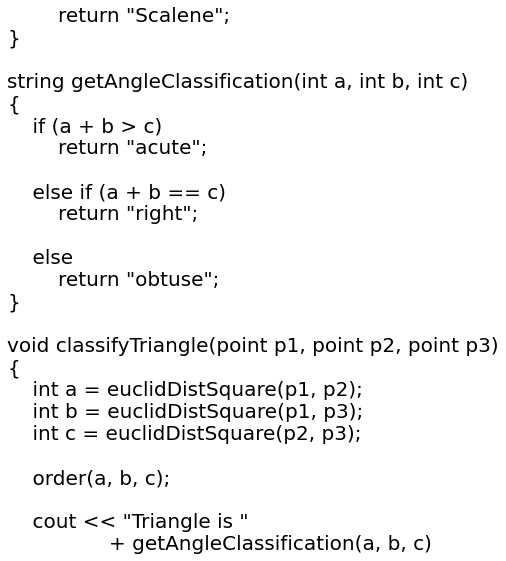

In [14]:
def display_text(
        content: str, 
        font_path: str = "../consolas/vscode_windows_font.TTF",
        font_size: int = 20,
        debug: bool = False,
        ax=None):
    """Display content in matplotlib with the given font."""
    if ax is None:
        fig, ax = plt.subplots()
    else: 
        fig = plt.gcf()
    text_obj = ax.text(0, 0, content, fontsize=font_size, fontname=font_path)
    if not debug:
        ax.axis("off")
    return ax

display_text(
    content="".join(record["content_lines"]).replace("\t", "    ")
)

### 2. Screen Recording (source: OBS video)

In [15]:
import ffmpeg
from pprint import pprint # for printing Python dictionaries in a human-readable way

def get_tot_n_frames(video_path: str):
    """Get the total number of frames."""

    data = ffmpeg.probe(video_path)["streams"][0]
    return {
        "tot_n_frames": data["duration_ts"],
        "fps": data["avg_frame_rate"].replace("/1", "")
    }


def get_video_path(user_folder: str, task_nr: int) -> str:
    """Get the path of the video file."""
    all_video_paths = [
        (
            int(re.search(r'.*\s([0-9])+.avi', Path(v).name).group(1)), 
            v
        )
        for v in os.listdir(user_folder) 
        if v.endswith(".avi")
    ]
    target_video_path = [
        v for nr, v in all_video_paths
        if nr == task_nr
    ][0]
    return join(user_folder, target_video_path)

get_tot_n_frames(video_path=VIDEO_FILE)

get_video_path(user_folder=f"../participants/{USER_NAME}", task_nr=3)

'../participants/Pedro/video_export_07-26-22-15.15.14_Pedro 3.avi'

### 3. Eye Tracking Data (source: eye tracker)

In [16]:
def offset_time_based_on_time_column(df: pd.DataFrame):
    """Offset eye tracker data based on the offset in the time column."""
    time_col = [c for c in df.columns if "TIME(" in c][0]
    print(time_col)
    # read the time stamp in the time_col column
    time_string = time_col.split(" ")[1]
    # get the date and time of the snapshot
    date_time = datetime.strptime(
        time_string,
        #"%H-%M-%S-%I-%f"
        "%H:%M:%S.%f)"
    )
    # print(date_time)
    # get the number of milliseconds seconds in date time
    offset = (date_time - datetime(1900, 1, 1)).total_seconds() * 1000
    df["time_abs"] = df[time_col] * 1000 + offset
    df["FPOGS_abs"] = df["FPOGS"] * 1000 + offset
    return df

In [17]:
def read_eye_tracker_fixations(user_folder: str, task_nr: int):
    """Reads eye tracker fixation for the given user."""
    # get all csv files in the user folder
    csv_files = [
        (
            int(re.search(r'^[a-zA-Z ]+([0-9])+', Path(f).name).group(1)), 
            Path(f).name
        )
        for f in os.listdir(user_folder) 
        if f.endswith(".csv") and Path(f).name.startswith(USER_NAME)]
    # keep only fixations
    csv_files = [f for f in csv_files if "fixations" in f[1]]
    # get the path of the csv file for the given task
    csv_file = [f for f in csv_files if f[0] == task_nr][0][1]
    # read the csv file
    df = pd.read_csv(join(user_folder, csv_file))

    return df

df = read_eye_tracker_fixations(
    user_folder=f"../participants/{USER_NAME}", task_nr=0)
df = offset_time_based_on_time_column(df)
df

TIME(2022/07/21 14:39:28.700)


MEDIA_ID MEDIA_NAME    CNT  TIME(2022/07/21 14:39:28.700)  \
0           0  NewMedia0    207                        3.34814   
1           0  NewMedia0    292                        4.72314   
2           0  NewMedia0    309                        4.99805   
3           0  NewMedia0    362                        5.85498   
4           0  NewMedia0    380                        6.14648   
..        ...        ...    ...                            ...   
537         0  NewMedia0  17530                      283.53711   
538         0  NewMedia0  17568                      284.15234   
539         0  NewMedia0  17591                      284.52393   
540         0  NewMedia0  17605                      284.75000   
541         0  NewMedia0  17635                      285.23584   

     TIMETICK(f=10000000)    FPOGX    FPOGY      FPOGS    FPOGD  FPOGID  ...  \
0             53856294535  0.82882  0.80970    0.00000  3.34814       1  ...   
1             53870044126  0.82774  0.79704    3.75244  0.97070       2  ...   
2             53872791896  0.58509  0.87309    4.78760  0.21045       3  ...   
3             53881364945  0.83714  0.80413    5.06250  0.79248       4  ...   
4             53884277860  0.78540  0.79571    5.91992  0.22656       5  ...   
..                    ...      ...      ...        ...      ...     ...  ...   
537           56658186108  0.29147  0.59534  282.79346  0.74365     538  ...   
538           56664336728  0.28813  0.57513  283.55322  0.59912     539  ...   
539           56668052569  0.35425  0.42637  284.21680  0.30713     540  ...   
540           56670314619  0.46538  0.33905  284.54004  0.20996     541  ...   
541           56675169841  0.45199  0.33910  284.76660  0.46924     542  ...   

     TTLV  PIXS  PIXV  AOI  SACCADE_MAG  SACCADE_DIR  VID_FRAME  Unnamed: 51  \
0       0   0.0     0  NaN      0.00000      0.00000          0          NaN   
1       0   0.0     0  NaN     13.82918     98.62319          0          NaN   
2       0   0.0     0  NaN    473.07263    189.99828          0          NaN   
3       0   0.0     0  NaN    489.63342      8.74907          0          NaN   
4       0   0.0     0  NaN     99.75629    174.76974          0          NaN   
..    ...   ...   ...  ...          ...          ...        ...          ...   
537     0   0.0     0  NaN     17.13868    204.69525          0          NaN   
538     0   0.0     0  NaN     22.74939    106.37292          0          NaN   
539     0   0.0     0  NaN    204.76402     51.68502          0          NaN   
540     0   0.0     0  NaN    233.28120     23.84459          0          NaN   
541     0   0.0     0  NaN     25.70886    180.12039          0          NaN   

        time_abs    FPOGS_abs  
0    52772048.14  52768700.00  
1    52773423.14  52772452.44  
2    52773698.05  52773487.60  
3    52774554.98  52773762.50  
4    52774846.48  52774619.92  
..           ...          ...  
537  53052237.11  53051493.46  
538  53052852.34  53052253.22  
539  53053223.93  53052916.80  
540  53053450.00  53053240.04  
541  53053935.84  53053466.60  

[542 rows x 54 columns]

In [18]:
def get_eye_tracker_fixations_at(df: pd.DataFrame, time_ms: int, time_col: str = "FPOGS_abs"):
    """Get the eye tracker fixations at a given time."""
    df = df.sort_values(by=time_col)
    df_previous_states = df.loc[df[time_col] < time_ms]
    # get last row
    last_row = df_previous_states.iloc[-1].to_dict()
    return last_row

get_eye_tracker_fixations_at(df, time_ms=52774846)

{'MEDIA_ID': 0,
 'MEDIA_NAME': 'NewMedia0',
 'CNT': 380,
 'TIME(2022/07/21 14:39:28.700)': 6.14648,
 'TIMETICK(f=10000000)': 53884277860,
 'FPOGX': 0.7854,
 'FPOGY': 0.79571,
 'FPOGS': 5.91992,
 'FPOGD': 0.22656,
 'FPOGID': 5,
 'FPOGV': 1,
 'BPOGX': 0.85091,
 'BPOGY': 0.8106,
 'BPOGV': 1,
 'CX': 1.33802,
 'CY': 0.18889,
 'CS': 0,
 'USER': nan,
 'LPCX': 0.24828,
 'LPCY': 0.55838,
 'LPD': 35.31396,
 'LPS': 1.05406,
 'LPV': 1,
 'RPCX': 0.55308,
 'RPCY': 0.56041,
 'RPD': 34.10196,
 'RPS': 1.05406,
 'RPV': 1,
 'BKID': 0,
 'BKDUR': 0.0,
 'BKPMIN': 3,
 'LPMM': 5.83347,
 'LPMMV': 1,
 'RPMM': 5.86246,
 'RPMMV': 1,
 'DIAL': 0.0,
 'DIALV': 0,
 'GSR': 0,
 'GSRV': 0,
 'HR': 0,
 'HRV': 0,
 'HRP': 0,
 'TTL0': 1,
 'TTL1': 1,
 'TTLV': 0,
 'PIXS': 0.0,
 'PIXV': 0,
 'AOI': nan,
 'SACCADE_MAG': 99.75629,
 'SACCADE_DIR': 174.76974,
 'VID_FRAME': 0,
 'Unnamed: 51': nan,
 'time_abs': 52774846.48,
 'FPOGS_abs': 52774619.92}

### 4. Synchronization

In [22]:
import yaml
import calendar
from datetime import timedelta

def get_time_annotation_per_task(
        user_folder: str, task_nr: int):
    """Read the time annotation on the video."""
    # read annotation
    annotation_path = join(user_folder, f"annotation_{task_nr}.yaml")
    print(annotation_path)
    with open(annotation_path, "r") as f:
        annotation = yaml.safe_load(f)
    # parse the dates
    start_task_rel = datetime.strptime(annotation["task_start"],"%M:%S")
    end_task_rel = datetime.strptime(annotation["task_end"],"%M:%S")
    synch_rel = datetime.strptime(annotation["sync_timestamp_video"],"%M:%S")
    synch_abs = datetime.strptime(annotation["sync_timestamp_pc_clock"],"%H:%M")
    positive_offset = synch_abs - synch_rel
    start_task_abs = positive_offset + start_task_rel
    end_task_abs = positive_offset + end_task_rel
    annotation["positive_offset_ts_ms"] = int(positive_offset.total_seconds()) * 1000
    annotation["start_task_abs_ts_ms"] = \
        (start_task_abs - datetime(1900, 1, 1)).total_seconds() * 1000
    annotation["end_task_abs_ts_ms"] = \
        (end_task_abs - datetime(1900, 1, 1)).total_seconds() * 1000
    return annotation

get_time_annotation_per_task(
    user_folder=f"../participants/{USER_NAME}", 
    task_nr=0)

../participants/Pedro/annotation_0.yaml


{'task_start': '1:30',
 'task_end': '3:30',
 'sync_timestamp_pc_clock': '14:41',
 'sync_timestamp_video': '1:31',
 'shift_text_ms': 0,
 'shift_eye_data_ms': 0,
 'positive_offset_ts_ms': 52769000,
 'start_task_abs_ts_ms': 52859000.0,
 'end_task_abs_ts_ms': 52979000.0}

## Visual Inspection

<AxesSubplot:xlabel='CX', ylabel='Count'>

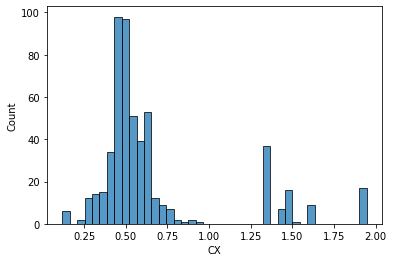

In [ ]:
import seaborn as sns
sns.histplot(
    data=df,
    x="CX"
)

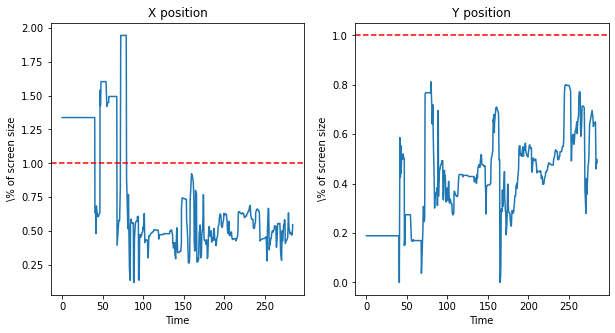

In [ ]:
def inspect_mouse_cursor_position(df: pd.DataFrame):
    """Inspect the x and y position of the mouse cursor."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    ax_x_pos = axes[0]
    ax_y_pos = axes[1]
    sns.lineplot(
        data=df,
        x="FPOGS",
        y="CX",
        ax=ax_x_pos
    )
    ax_x_pos.set_title("X position")
    ax_x_pos.set_xlabel("Time")
    ax_x_pos.set_ylabel("\% of screen size")
    ax_x_pos.axhline(1, color="red", linestyle="--")
    sns.lineplot(
        data=df,
        x="FPOGS",
        y="CY",
        ax=ax_y_pos
    )
    ax_y_pos.set_title("Y position")
    ax_y_pos.set_xlabel("Time")
    ax_y_pos.set_ylabel("\% of screen size")
    ax_y_pos.axhline(1, color="red", linestyle="--")
    # compute the last timestam after which 
    # all the data are between zero and one
    plt.show()

inspect_mouse_cursor_position(df)

In [ ]:
52800000.0 / 3600 / 1000

14.666666666666666

../participants/Pedro/annotation_0.yaml
Earliest Eye-Tracker Data (millisec):  52858779.0
TIME(2022/07/21 14:39:28.700)


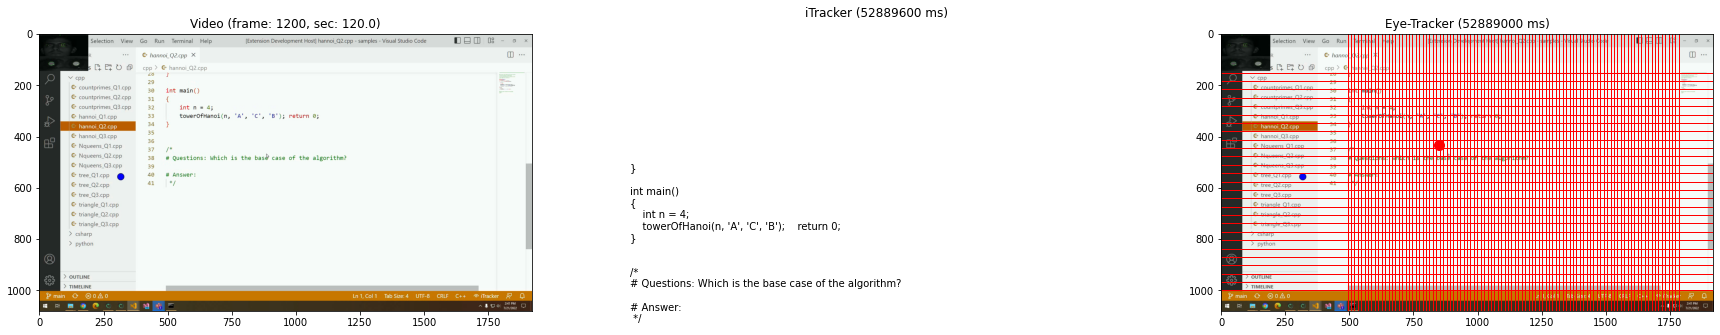

TIME(2022/07/21 14:39:28.700)


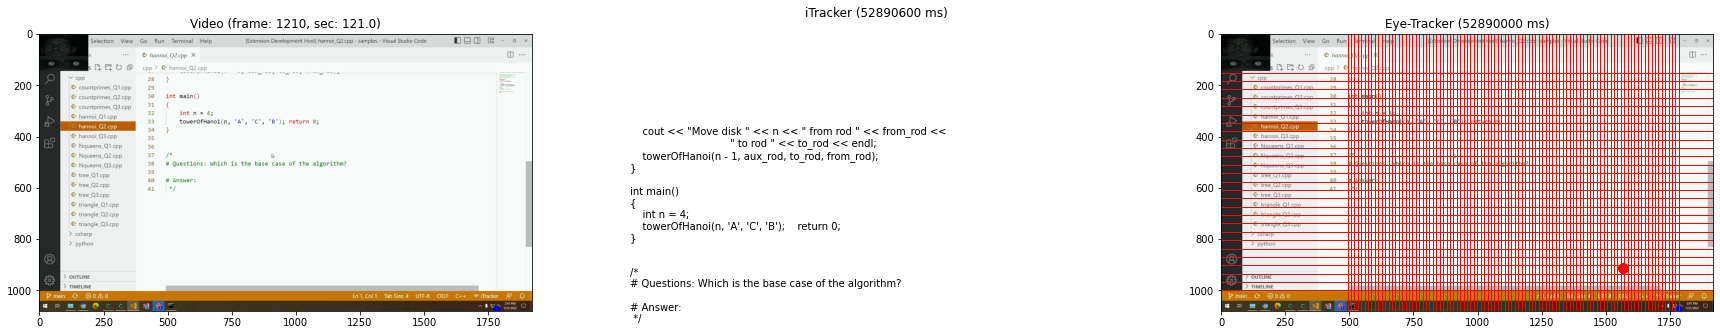

TIME(2022/07/21 14:39:28.700)


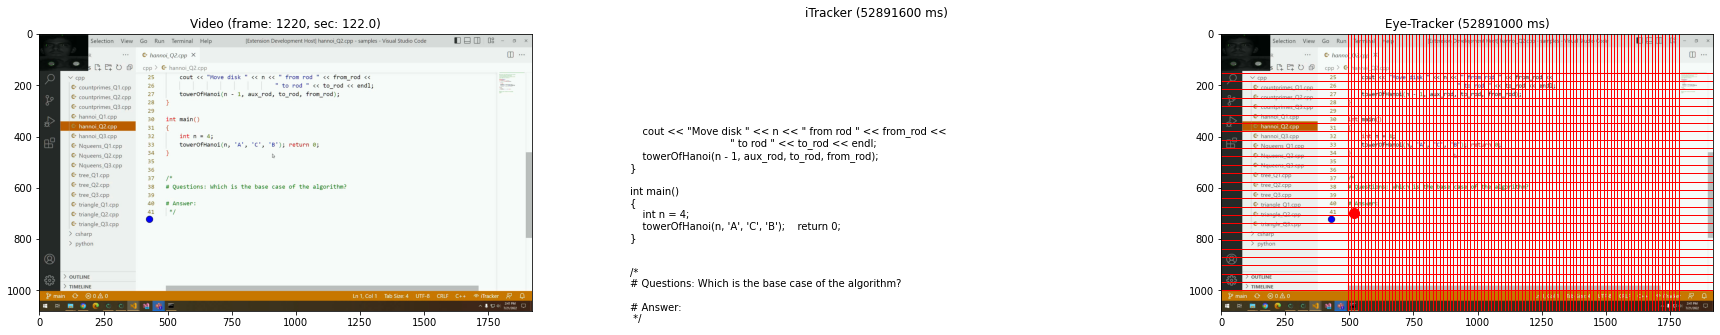

TIME(2022/07/21 14:39:28.700)


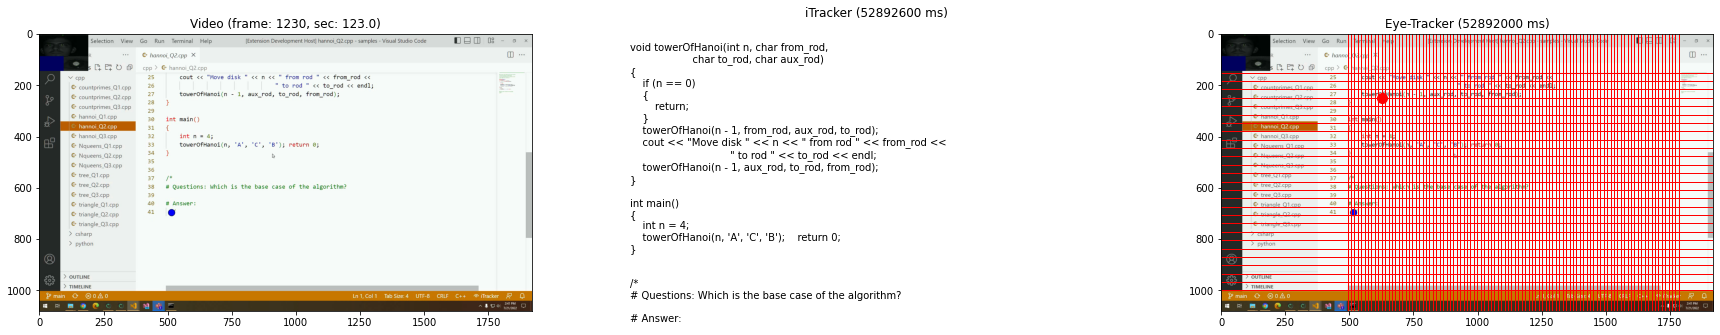

TIME(2022/07/21 14:39:28.700)


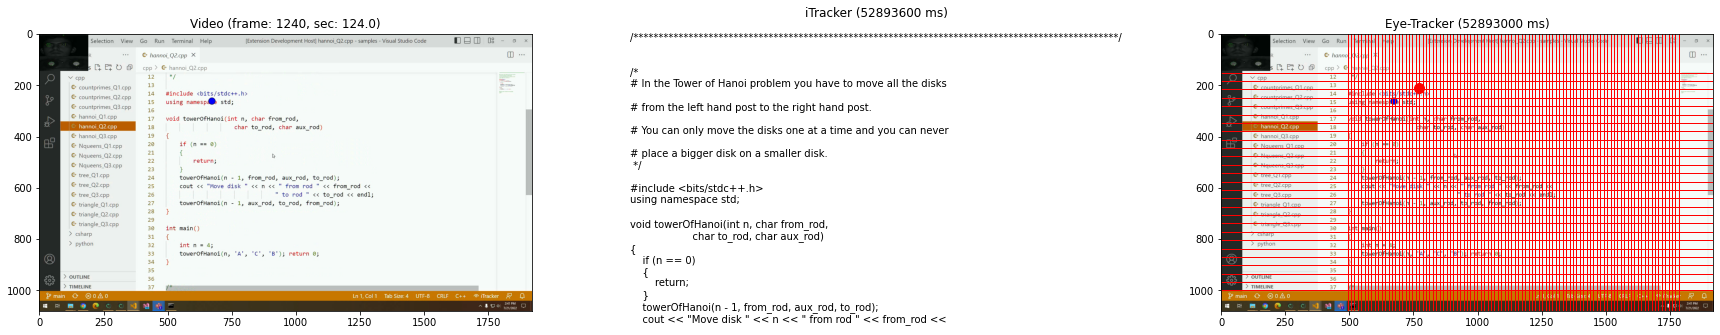

In [31]:
import tempfile

def inspect_video_vs_code_text(
        user_folder: str,
        task_nr: int, 
        every_n_seconds: int = 1,
        start_second: int = 120,
        n_samples: int = 5):
    """Inspect the video vs the iTracker data every 5 seconds."""
    # reason on millisec
    start_millisec = start_second * 1000
    every_n_millisec = every_n_seconds * 1000

    video_path = get_video_path(user_folder, task_nr)
    fps = int(get_tot_n_frames(video_path)["fps"])
    # get video offset in ms
    annotation = get_time_annotation_per_task(
        user_folder=user_folder, 
        task_nr=task_nr)
    positive_offset_ts_ms = annotation["positive_offset_ts_ms"]

    # read the eye tracker data
    df_snap = read_textual_snapshot(user_folder)
    earliest_itracker_data_ts_ms  = df_snap["time"].min()
    print("Earliest Eye-Tracker Data (millisec): ", earliest_itracker_data_ts_ms)

    # check if the eye tracker has enough data
    if earliest_itracker_data_ts_ms > start_millisec + positive_offset_ts_ms:
        raise Exception(
            f"The eye tracker data is not available before the participants"
            "opens a file. Try increasing the start_second value. "
        )


    for i in range(start_millisec, start_millisec + every_n_millisec * n_samples, every_n_millisec):
        fig, axes = plt.subplots(1, 3, figsize=(30, 5.5))
        ax_video = axes[0]
        ax_itracker = axes[1]
        ax_eye = axes[2]

        # get video frame
        video_time_millisec = i
        video_time_frame = round(video_time_millisec / 1000 * fps)

        tmp_dir = tempfile.TemporaryDirectory(dir="./tmp")
        img, img_path = get_video_image(
            video_path=video_path, 
            frame_number=video_time_frame,
            output_folder=tmp_dir.name)
        ax_video.imshow(img)
        ax_video.set_title(f"Video (frame: {video_time_frame}, sec: {video_time_millisec/1000})")

        # get the itracker data
        itracker_time_millisec = video_time_millisec + positive_offset_ts_ms + int(annotation["shift_text_ms"])
        record = get_textual_snapshot_at(df_snap, time_ms=itracker_time_millisec)
        display_text(
            content="".join(record["content_lines"]).replace("\t", "    "),
            font_size=10,
            debug=False,
            ax=ax_itracker,
        )
        ax_itracker.set_title(f"iTracker ({itracker_time_millisec} ms)")

        # get the eye-tracker data
        eye_tracker_fixation_time_millisec = video_time_millisec + positive_offset_ts_ms + int(annotation["shift_eye_data_ms"])
        df_eye = read_eye_tracker_fixations(
            user_folder=user_folder,
            task_nr=task_nr,
        )
        df_eye = offset_time_based_on_time_column(df_eye)

        current_fixation = get_eye_tracker_fixations_at(df_eye, 
            time_ms=eye_tracker_fixation_time_millisec)
        fixation_X = current_fixation["FPOGX"]
        fixation_Y = current_fixation["FPOGY"]

        if USER_ZOOM == "M":
            marker_params = {
                "path_marker_top_left": "../markers/top_left_marker.png", 
                "path_marker_bottom_right": "../markers/bottom_right_marker.png",
                "top_left_offsets": (182, 109),
                "bottom_right_offsets": (107, 6),
            }
            col_lines_params = {"n_lines": 26, "n_col": 97,}
        elif USER_ZOOM == "L":
            marker_params = {
                "path_marker_top_left": "../markers/top_left_marker_zoomed.png", 
                "path_marker_bottom_right": "../markers/bottom_right_marker_zoomed.png",
                "top_left_offsets": (220, 125),
                "bottom_right_offsets": (90, -25),
            }
            col_lines_params = {"n_lines": 20, "n_col": 71,}

        code_screen_coordinate_abs = get_code_coordinates(
            screenshot_path=img_path,
            percentage_format=False,
            debug=False,
            **marker_params)

        ax_eye.set_title(f"Eye-Tracker ({eye_tracker_fixation_time_millisec} ms)")
        get_char_coordinates(
            eye_x_perc=fixation_X, eye_y_perc=fixation_Y,
            pixel_screen_width=1920, pixel_screen_height=1080,
            screen_path=img_path,
            ax=ax_eye,
            debug=True,
            **col_lines_params,
            **code_screen_coordinate_abs)
        tmp_dir.cleanup()
    
inspect_video_vs_code_text(
    user_folder=f"../participants/{USER_NAME}",
    task_nr=0,
)

## Synchronized with entire screen

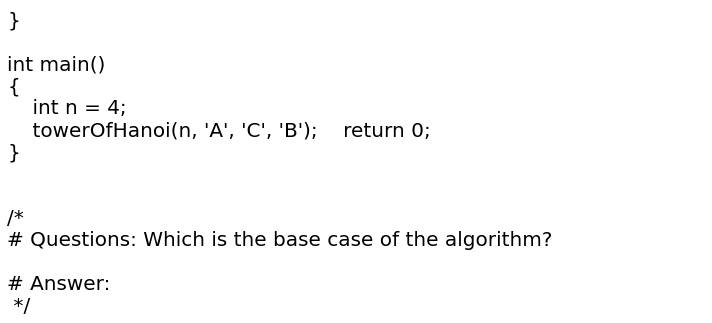

In [64]:

itracker_time_millisec = 52889600
user_folder = f"../participants/{USER_NAME}"
df_snap = read_textual_snapshot(user_folder)
record = get_textual_snapshot_at(df_snap, time_ms=itracker_time_millisec)
fig, ax_itracker = plt.subplots(1, 1, figsize=(10, 5))
display_text(
    content="".join(record["content_lines"]).replace("\t", "    "),
    font_size=20,
    debug=False,
    ax=ax_itracker,
)

#ax_itracker.set_ylim(100, 300)
plt.tight_layout()
fig.savefig("../markers/synch_text.jpg")

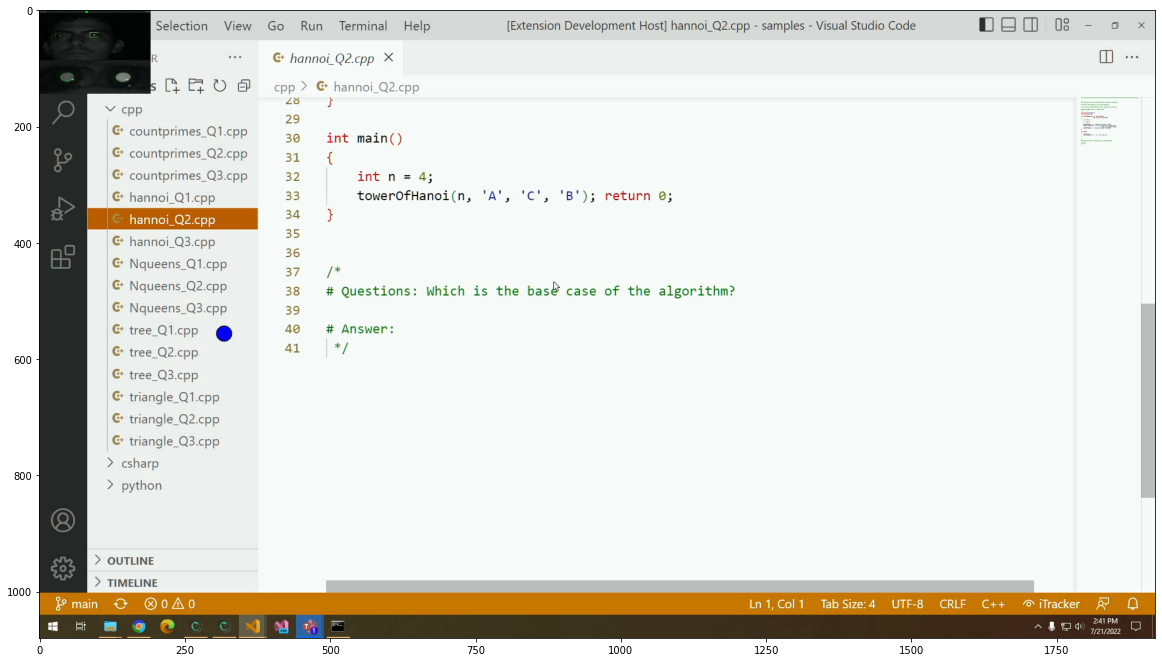

In [65]:
img, img_path =get_video_image(
    video_path="../participants/UconsumerU/video_export_07-26-22-15.10.45_UconsumerU 0.avi",
    frame_number=1200,
    output_folder="../participants/UconsumerU/frames")
plt.imshow(img)
plt.gcf().set_size_inches((SIZE, SIZE))

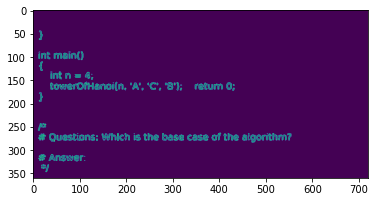

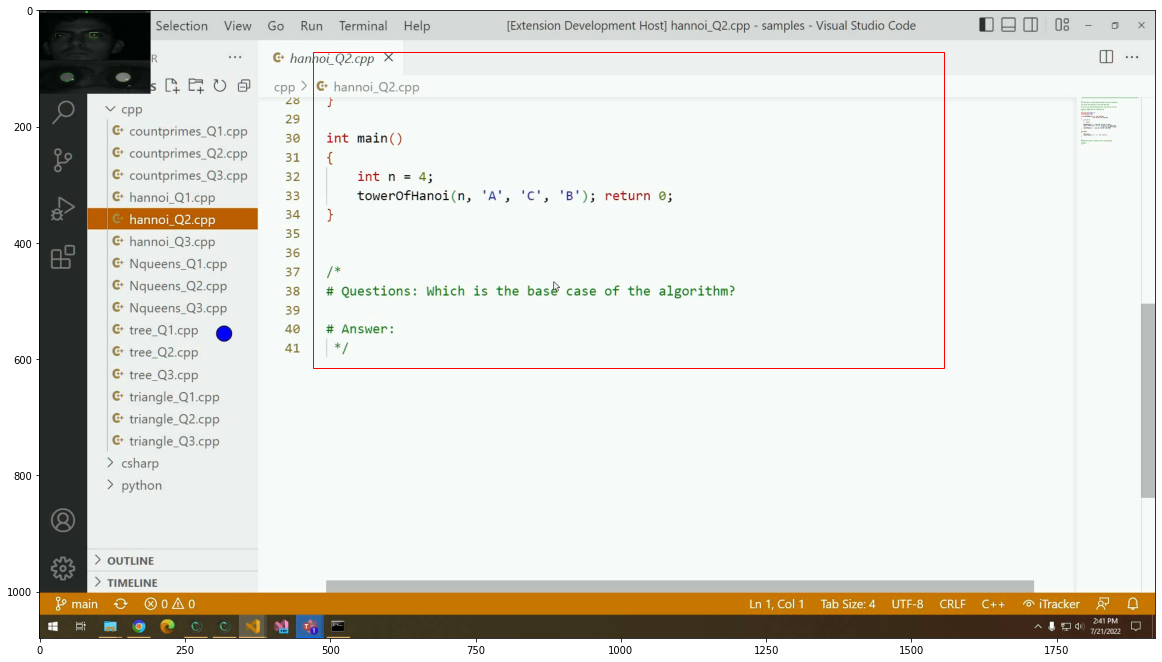

(470, 72, 1556, 615)

In [67]:
get_coordinate_of(
    marker_path="../markers/synch_text.jpg",
    screen_path=img_path,
    debug=True,
)

tmp_dir.name:  ./tmp/tmpqipa8r8d


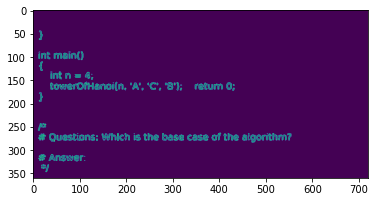

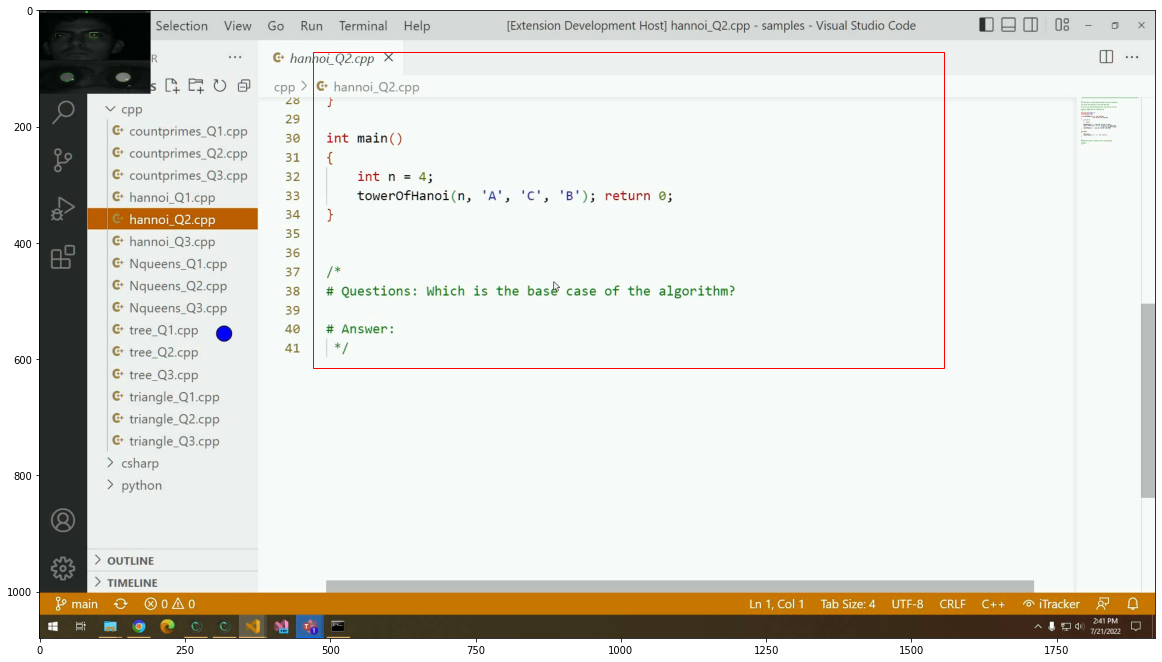

(470, 72, 1556, 615)

In [75]:
def is_perfect_match(
        video_path: str,
        content: str,
        video_ts_ms: int, 
        debug: bool = False,):
    """Check if the code matches the video image."""
    tmp_dir = tempfile.TemporaryDirectory(dir="./tmp")
    
    fps = int(get_tot_n_frames(video_path)["fps"])
    video_time_frame = round(video_ts_ms / 1000 * fps)
    # extract the video frame
    img, img_path =get_video_image(
        video_path=video_path,
        frame_number=video_time_frame,
        output_folder=tmp_dir.name)
    # get the itracker data and create text image
        
    fig, ax_itracker = plt.subplots(1, 1, figsize=(10, 5))
    display_text(
        content=content,
        font_size=20,
        debug=False,
        ax=ax_itracker,
    )
    plt.tight_layout()
    print("tmp_dir.name: ", tmp_dir.name)
    marker_path = join(str(tmp_dir.name), "synch_text.jpg")
    fig.savefig(marker_path)
    plt.close()
    

    # match the text in the video frame
    coord_of_text = get_coordinate_of(
        marker_path=marker_path,
        screen_path=img_path,
        debug=debug,
    )

    tmp_dir.cleanup()
    return coord_of_text


user_folder = f"../participants/{USER_NAME}"
df_snap = read_textual_snapshot(user_folder)
record = get_textual_snapshot_at(df_snap, time_ms=52889600)
content = "".join(record["content_lines"]).replace("\t", "    ")

is_perfect_match(
    video_path="../participants/UconsumerU/video_export_07-26-22-15.10.45_UconsumerU 0.avi",
    content=content,
    video_ts_ms=120000,
    debug=True
)

tmp_dir.name:  ./tmp/tmp1v8xozyh


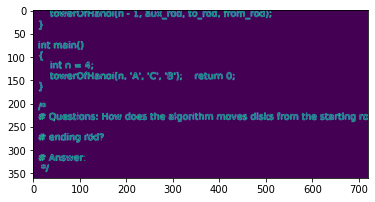

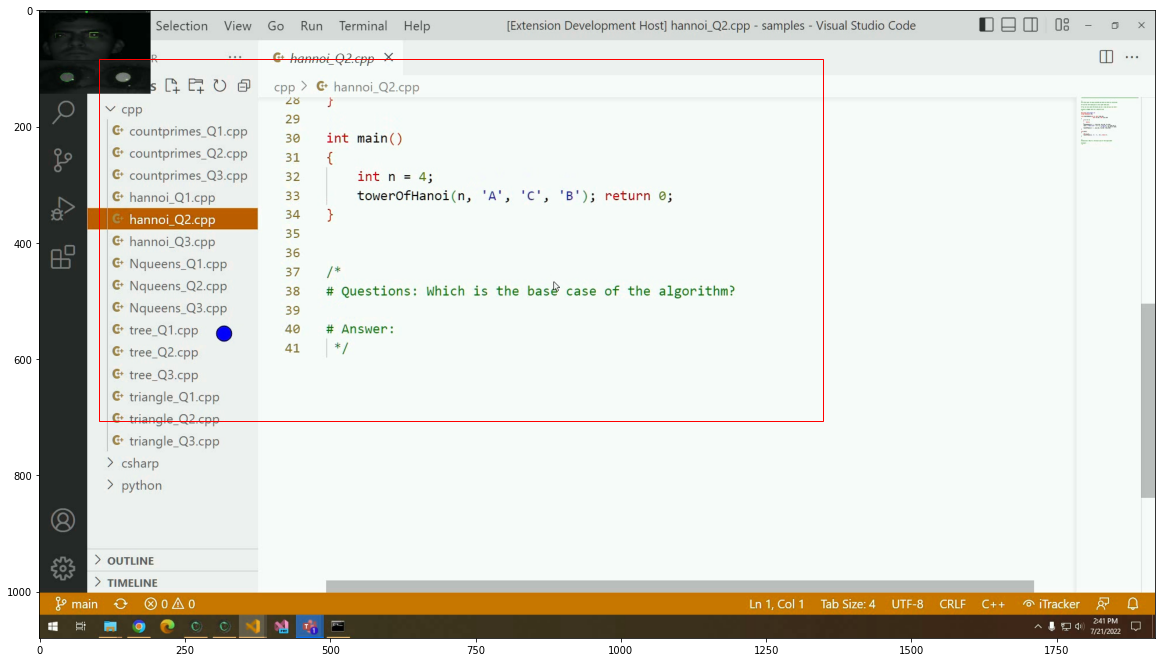

tmp_dir.name:  ./tmp/tmp3d1d5uem


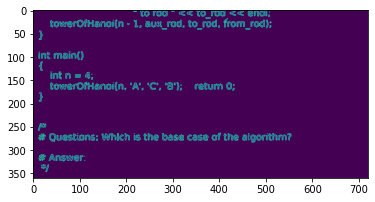

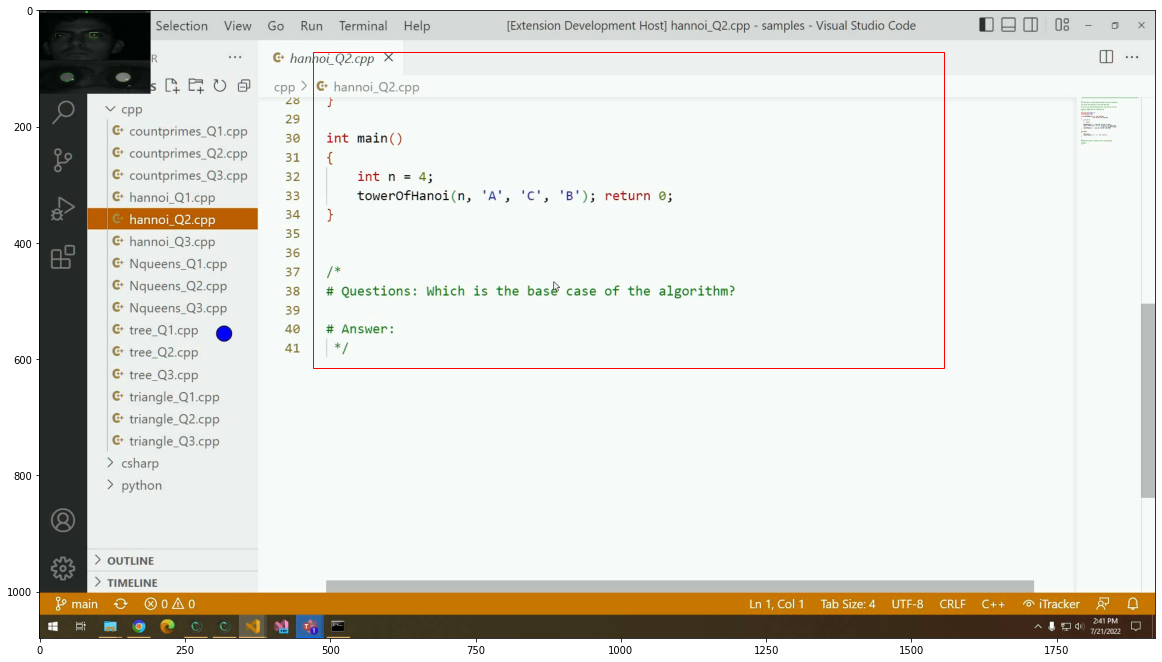

tmp_dir.name:  ./tmp/tmprajbik4f


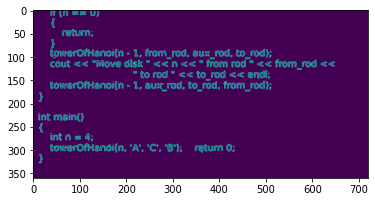

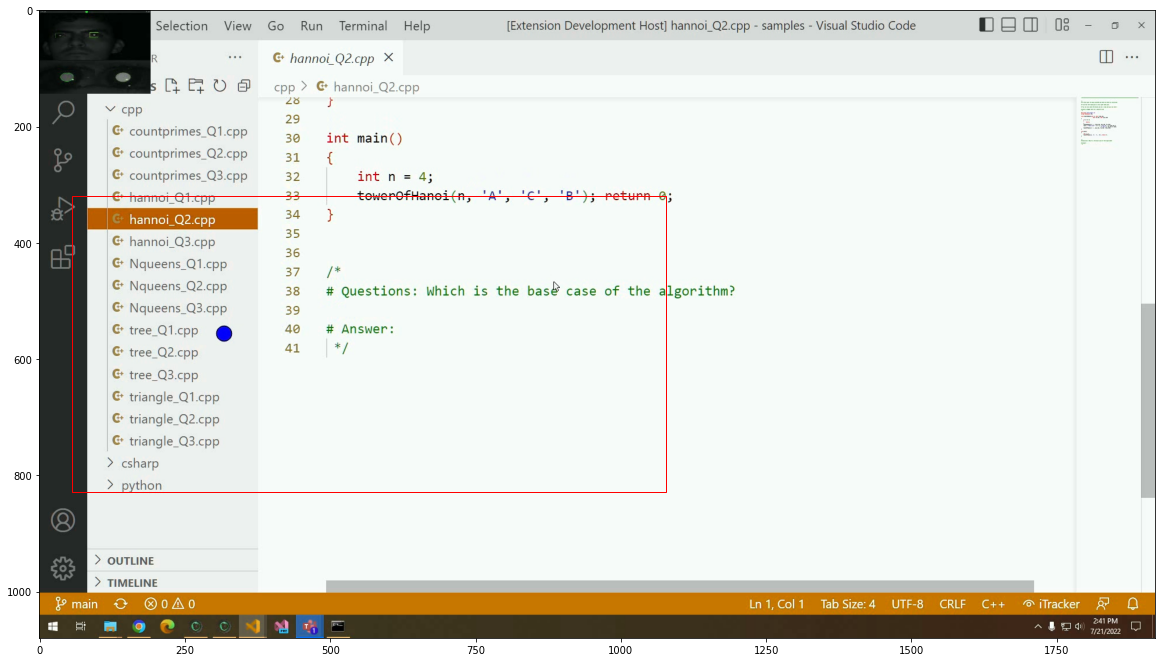

tmp_dir.name:  ./tmp/tmpgh2i0_rb


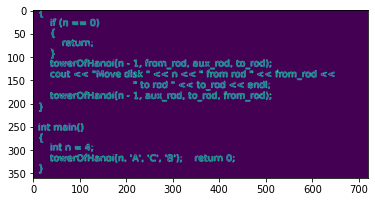

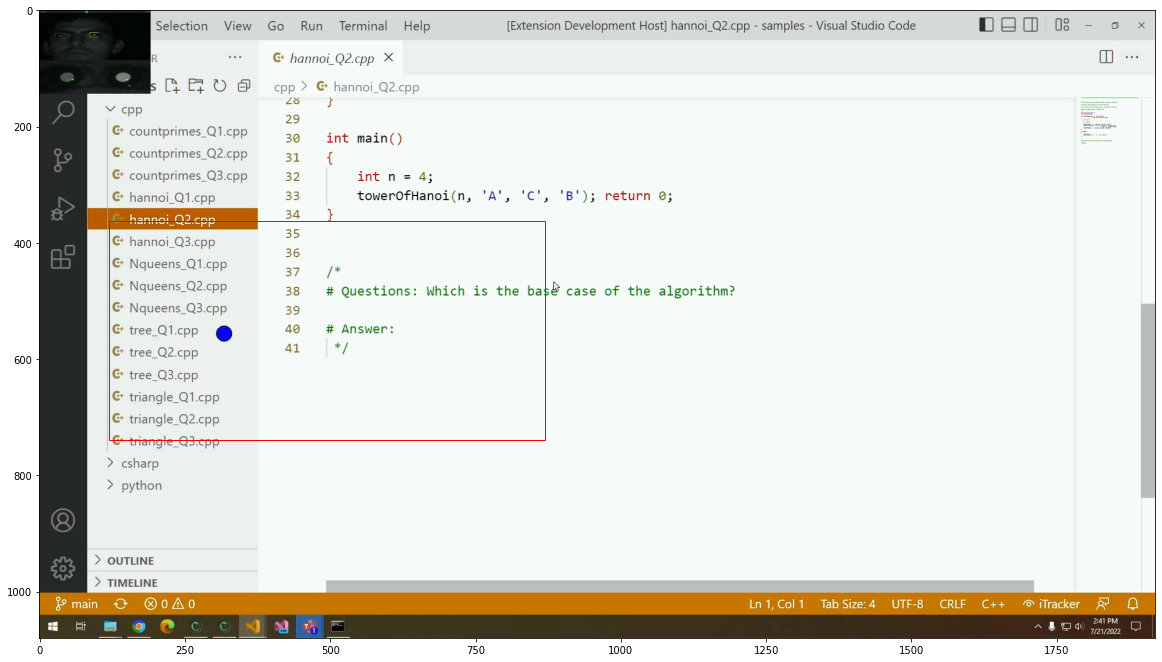

tmp_dir.name:  ./tmp/tmpeib_xd2i


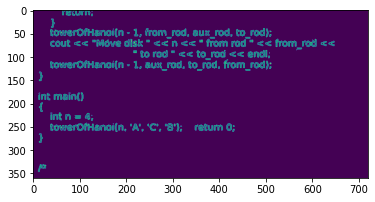

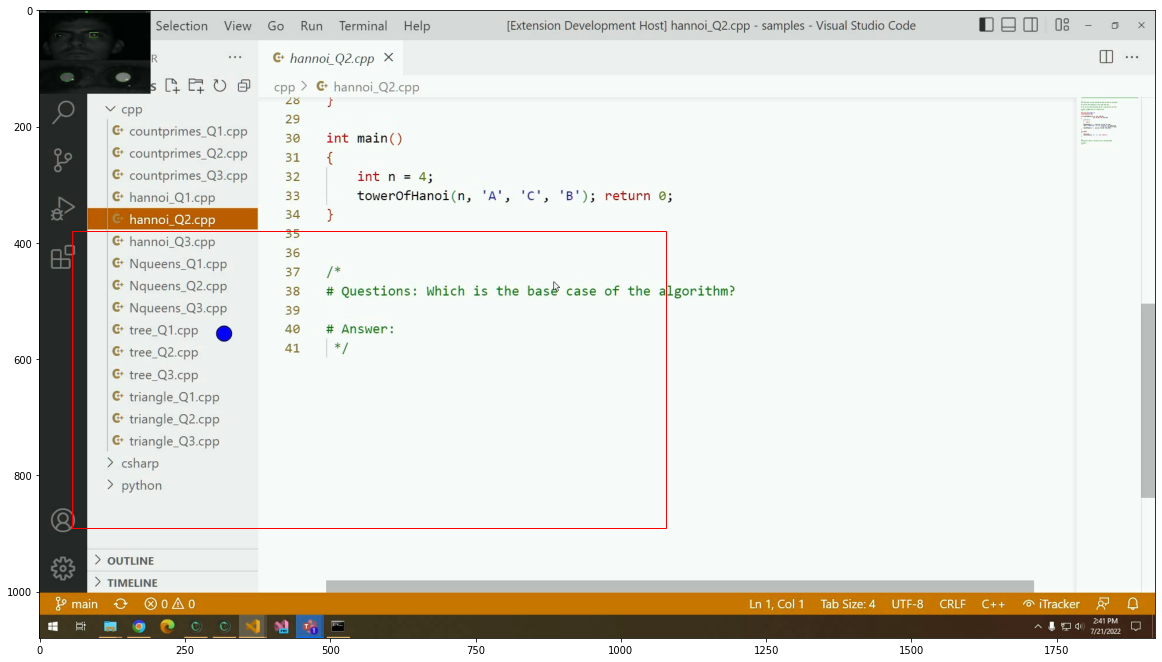

tmp_dir.name:  ./tmp/tmpfamrb2g_


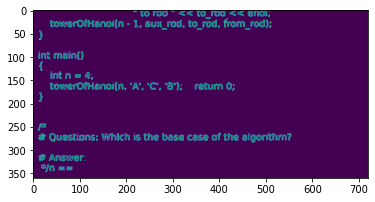

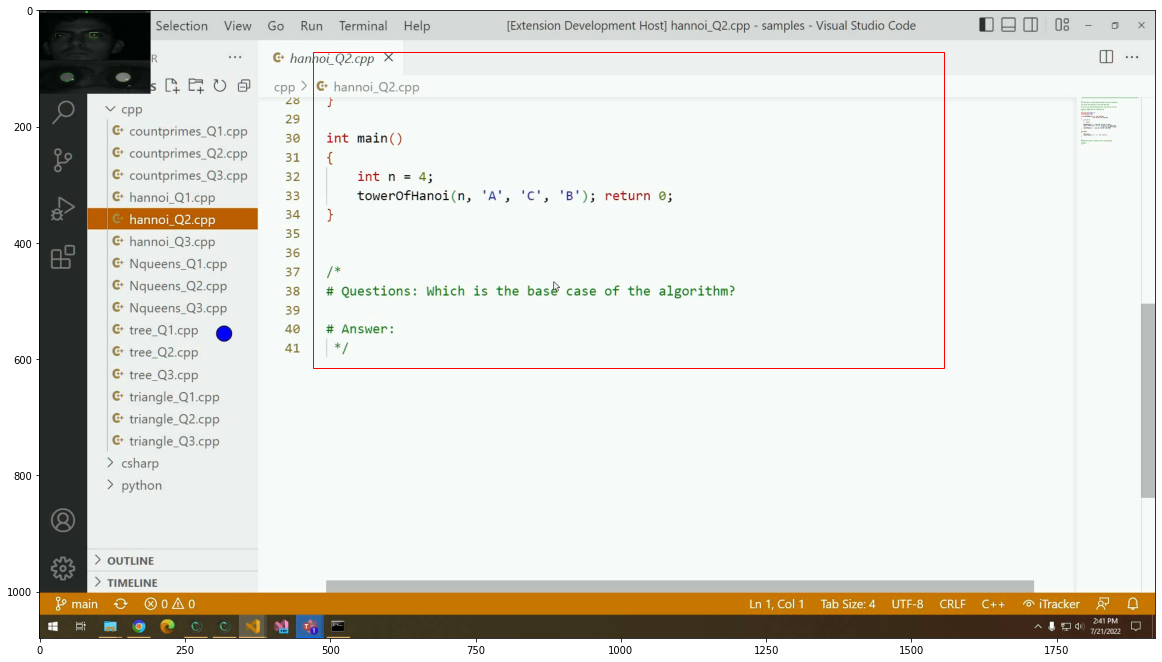

tmp_dir.name:  ./tmp/tmpalcvxsd0


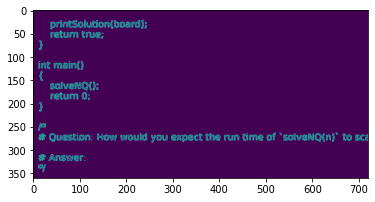

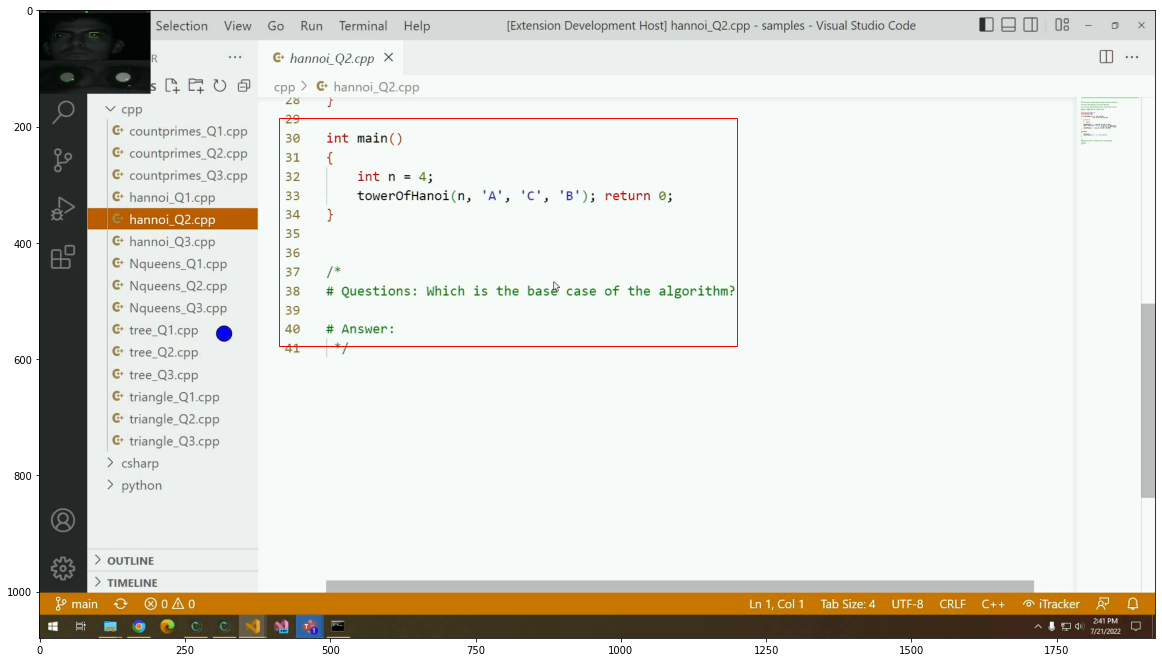

[(52858779.0, (103, 84, 1347, 706)),
 (52880750.0, (470, 72, 1556, 615)),
 (52892766.0, (56, 319, 1077, 829)),
 (52900165.0, (119, 363, 870, 739)),
 (52976540.0, (56, 380, 1077, 890)),
 (53046976.0, (470, 72, 1556, 615)),
 (53231523.0, (412, 185, 1199, 578))]

In [79]:
def get_closest_snapshots(
        df: pd.DataFrame, 
        anchor_ts_ms: int,
        col_time: str = "time",
        col_content: str = "content_lines",
        n_tot_snapshots: int = 10,
        distance_between_snapshots: int = 20):
    """Get the snapshots in the surrounding of the current snapshot.
    
    Half of the value of n_tot_snapshots decides how many snapshots to include 
    with a timestamp lower or equal than the anchor timestamp, and the same 
    parameter decides also how many snapshots to include with a timestamp higher 
    than the snapshot. Note that in the end the interval is equal.

    Returns:
     [
        (ts_ms_1, content_1),
        ...
        (ts_ms_10, content_10),
     ]
    """
    df = df.copy().sort_values(by=col_time)
    df = df.iloc[::distance_between_snapshots, :]
    n_before = n_after = n_tot_snapshots // 2
    df_before = df[df[col_time] <= anchor_ts_ms].iloc[-n_before:]
    df_after = df[df[col_time] > anchor_ts_ms].iloc[:n_after]
    df_closest = pd.concat([df_before, df_after])
    records = df_closest.to_dict("records")
    return [
        (r[col_time], "".join(r[col_content]).replace("\t", "    ")) 
        for r in records]


def find_closest_snapshot(
        video_path: str,
        video_ts_ms: int, 
        df_text_snapshots: pd.DataFrame,
        guess_ts_ms: int,
        n_checks: int = 10,
        debug: bool = False,):
    """Given a timeframe find the closest snapshot.
    
    The parameter guess_ts_ms give a hint on where to look for the correct 
    snapshot, beside that precise snapshot, it will check the snapshots right 
    before and right after that one. How many snapshots to check is decided by 
    the n_checks, half checks before and half checks after the current snapshot.
    """
    closest_snapshots = get_closest_snapshots(
        df_text_snapshots,
        anchor_ts_ms=guess_ts_ms,
        n_tot_snapshots=n_checks,
    )
    candidates = []
    for candidate_ts, content in closest_snapshots:
        res = is_perfect_match(
            video_path=video_path,
            content=content,
            video_ts_ms=video_ts_ms, 
            debug=debug,
        )
        if res is not None:
            candidates.append((candidate_ts, res))
    return candidates

find_closest_snapshot(
    video_path="../participants/UconsumerU/video_export_07-26-22-15.10.45_UconsumerU 0.avi",
    video_ts_ms=120000,
    df_text_snapshots=df_snap,
    guess_ts_ms=52889600,
    n_checks=10,
    debug=True    
)